# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

In [14]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

In [15]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [16]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures")
RESULTS  = os.path.join(FIXTURES, "experiments", 'eventually-there-multi-20160219.json')
# RESULTS  = os.path.join(FIXTURES, "experiments", 'raft-quorum-multi-20160219.json')
# RESULTS  = os.path.join(FIXTURES, 'test-raft-multi.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [17]:
# Print report details 
def report_settings():
    table = defaultdict(list)
    exclude = frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals('settings')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if key == 'anti_entropy_delay': key = 'anti_entropy'
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)
    
    for idx, conf in enumerate(rvals('topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)

    return tabulate(table, headers='keys')

# print report_settings()

In [18]:
def report_accesses(access='write'):
    table = defaultdict(list)
    
    for idx, results in enumerate(rvals('results')):
        counts = Counter()
        eid = "e{:0>2}".format(idx)
        
        for (rid, loc, ts) in results.get(access, []):
            counts[rid] += 1
            counts['total'] += 1
        
        for rid, count in sorted(counts.items(), key=itemgetter(0)):
            if idx == 0:
                table[''].append(rid)
            table[eid].append(count)
    
    print "{} Accesses:\n".format(access.capitalize())
    print tabulate(table, headers='keys')
    return table

# table = report_accesses('read')

In [19]:
# table = report_accesses('write')

In [20]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))
    conf  = list(rvals('settings'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        data['variable (ms)'] = meta[idx]['variable']
        
        # Variable latency 
        latency = meta[idx]['variable'].rstrip('ms').strip().split('-')
        latency = sum(map(float, [ms for ms in latency if ms != 'N/A'])) / 2
        
        # Constant latency 
        if not latency:
            latency = float(meta[idx]['constant'].rstrip('ms').strip())
        
        data['mean latency (ms)'] = latency
        data['constant (ms)'] = meta[idx]['constant']
        data['users'] = conf[idx]['users']
        for key, values in results.iteritems():
            if key == 'visibility latency':
                data['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['visible writes'] = len(set([v[1] for v in values]))
            else:
                data[key] = len(values)
        
        data['ratio fully visible to writes'] = float(data['visible writes']) / float(data['write'])
        
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()
# print df

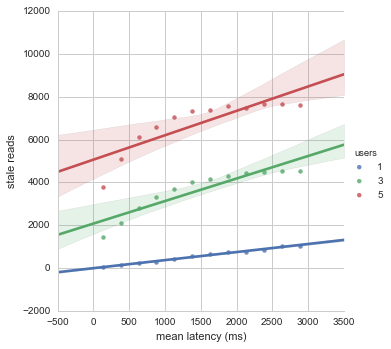

In [21]:
ax = sns.lmplot(x="mean latency (ms)", y="stale reads", hue='users', data=df)

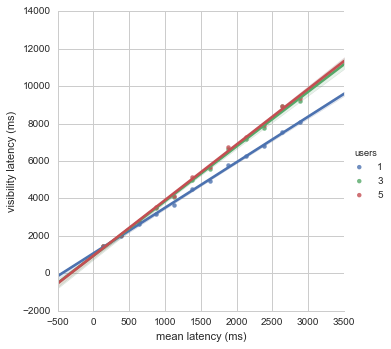

In [22]:
ax = sns.lmplot(x="mean latency (ms)", y="visibility latency (ms)", hue='users', data=df)

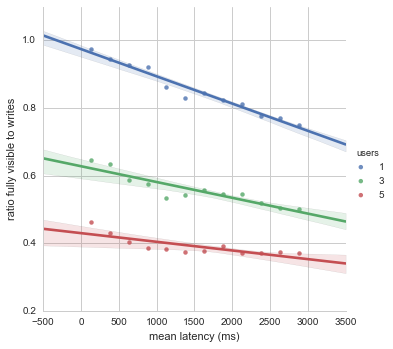

In [23]:
ax = sns.lmplot(x="mean latency (ms)", y="ratio fully visible to writes", hue='users', data=df)